# Welcome to Modal notebooks!

Write Python code and collaborate in real time. Your code runs in Modal's
**serverless cloud**, and anyone in the same workspace can join.

This notebook comes with some common Python libraries installed. Run
cells with `Shift+Enter`.

In [1]:
import os
import math
import random
from collections import Counter
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA A100 80GB PCIe


In [3]:
NUCLEOTIDES = ['A', 'T', 'G', 'C']
MASK_TOKEN = '[MASK]'
VOCAB = NUCLEOTIDES + [MASK_TOKEN]
VOCAB_SIZE = len(VOCAB)  # 5

NUC_TO_IDX = {nuc: idx for idx, nuc in enumerate(VOCAB)}
IDX_TO_NUC = {idx: nuc for idx, nuc in enumerate(VOCAB)}

CODON_TABLE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G',
}

STOP_CODONS = ['TAA', 'TAG', 'TGA']
START_CODON = 'ATG'

HUMAN_CODON_FREQ = {
    'TTT': 0.45, 'TTC': 0.55, 'TTA': 0.07, 'TTG': 0.13,
    'TCT': 0.18, 'TCC': 0.22, 'TCA': 0.15, 'TCG': 0.06,
    'TAT': 0.43, 'TAC': 0.57, 'TAA': 0.28, 'TAG': 0.20,
    'TGT': 0.45, 'TGC': 0.55, 'TGA': 0.52, 'TGG': 1.00,
    'CTT': 0.13, 'CTC': 0.20, 'CTA': 0.07, 'CTG': 0.41,
    'CCT': 0.28, 'CCC': 0.33, 'CCA': 0.27, 'CCG': 0.11,
    'CAT': 0.41, 'CAC': 0.59, 'CAA': 0.25, 'CAG': 0.75,
    'CGT': 0.08, 'CGC': 0.19, 'CGA': 0.11, 'CGG': 0.21,
    'ATT': 0.36, 'ATC': 0.48, 'ATA': 0.16, 'ATG': 1.00,
    'ACT': 0.24, 'ACC': 0.36, 'ACA': 0.28, 'ACG': 0.12,
    'AAT': 0.46, 'AAC': 0.54, 'AAA': 0.42, 'AAG': 0.58,
    'AGT': 0.15, 'AGC': 0.24, 'AGA': 0.20, 'AGG': 0.20,
    'GTT': 0.18, 'GTC': 0.24, 'GTA': 0.11, 'GTG': 0.47,
    'GCT': 0.26, 'GCC': 0.40, 'GCA': 0.23, 'GCG': 0.11,
    'GAT': 0.46, 'GAC': 0.54, 'GAA': 0.42, 'GAG': 0.58,
    'GGT': 0.16, 'GGC': 0.34, 'GGA': 0.25, 'GGG': 0.25,
}


In [4]:
class ProteinCodingDataset(Dataset):
    def __init__(self, sequences: List[str], seq_length: int = 300):
        self.sequences = sequences
        self.seq_length = seq_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Pad / truncate
        if len(seq) < self.seq_length:
            padding = ''.join(random.choices('ATGC', k=self.seq_length - len(seq)))
            seq = seq + padding
        else:
            seq = seq[:self.seq_length]

        indices = [NUC_TO_IDX.get(nuc, 0) for nuc in seq]
        return torch.tensor(indices, dtype=torch.long)


In [5]:
class ProteinCodingDataset(Dataset):
    def __init__(self, sequences: List[str], seq_length: int = 300):
        self.sequences = sequences
        self.seq_length = seq_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Pad / truncate
        if len(seq) < self.seq_length:
            padding = ''.join(random.choices('ATGC', k=self.seq_length - len(seq)))
            seq = seq + padding
        else:
            seq = seq[:self.seq_length]

        indices = [NUC_TO_IDX.get(nuc, 0) for nuc in seq]
        return torch.tensor(indices, dtype=torch.long)


In [6]:
def sequences_to_strings(indices: torch.Tensor) -> List[str]:
    sequences = []
    for seq_indices in indices:
        seq = ''.join([IDX_TO_NUC.get(int(idx), 'A') for idx in seq_indices])
        seq = seq.replace('[MASK]', random.choice('ATGC'))
        sequences.append(seq)
    return sequences

def compute_kmer_distribution(sequences: List[str], k: int = 3) -> Dict[str, float]:
    kmer_counts = Counter()
    total = 0

    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            if all(nuc in 'ATGC' for nuc in kmer):
                kmer_counts[kmer] += 1
                total += 1

    if total > 0:
        return {kmer: count / total for kmer, count in kmer_counts.items()}
    return {}

def jensen_shannon_divergence(p: Dict[str, float], q: Dict[str, float]) -> float:
    all_kmers = set(p.keys()) | set(q.keys())
    eps = 1e-10

    p_arr = np.array([p.get(k, eps) for k in all_kmers])
    q_arr = np.array([q.get(k, eps) for k in all_kmers])

    p_arr = p_arr / p_arr.sum()
    q_arr = q_arr / q_arr.sum()

    m = 0.5 * (p_arr + q_arr)

    def kl_div(a, b):
        mask = a > 0
        return np.sum(a[mask] * np.log(a[mask] / b[mask]))

    jsd = 0.5 * kl_div(p_arr, m) + 0.5 * kl_div(q_arr, m)
    return float(jsd)

def compute_gc_content(seq: str) -> float:
    gc = sum(1 for nuc in seq if nuc in 'GC')
    return gc / len(seq) * 100 if len(seq) > 0 else 0

def compute_cai(seq: str) -> float:
    if len(seq) < 3:
        return 0

    log_w_sum = 0
    n_codons = 0

    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        if codon in HUMAN_CODON_FREQ and CODON_TABLE.get(codon, '*') != '*':
            w = HUMAN_CODON_FREQ[codon]
            if w > 0:
                log_w_sum += math.log(w)
                n_codons += 1

    if n_codons == 0:
        return 0

    return math.exp(log_w_sum / n_codons)

def check_orf_validity(seq: str) -> bool:
    if len(seq) < 9:
        return False
    if seq[:3] != 'ATG':
        return False

    for i in range(3, len(seq) - 3, 3):
        codon = seq[i:i+3]
        if codon in STOP_CODONS:
            return False
    return True

def evaluate_sequences(generated_seqs: List[str], real_seqs: List[str]) -> Dict[str, float]:
    metrics = {}

    gen_kmer = compute_kmer_distribution(generated_seqs, 3)
    real_kmer = compute_kmer_distribution(real_seqs, 3)
    metrics['kmer_jsd'] = jensen_shannon_divergence(gen_kmer, real_kmer)

    gen_gc = [compute_gc_content(s) for s in generated_seqs]
    real_gc = [compute_gc_content(s) for s in real_seqs]
    metrics['real_gc_mean'] = float(np.mean(real_gc))
    metrics['gen_gc_mean'] = float(np.mean(gen_gc))
    metrics['real_gc_std'] = float(np.std(real_gc))
    metrics['gen_gc_std'] = float(np.std(gen_gc))

    gen_cai = [compute_cai(s) for s in generated_seqs]
    real_cai = [compute_cai(s) for s in real_seqs]
    metrics['real_cai_mean'] = float(np.mean(real_cai))
    metrics['gen_cai_mean'] = float(np.mean(gen_cai))

    gen_orf_valid = sum(1 for s in generated_seqs if check_orf_validity(s))
    real_orf_valid = sum(1 for s in real_seqs if check_orf_validity(s))
    metrics['real_orf_valid_%'] = real_orf_valid / len(real_seqs) * 100
    metrics['gen_orf_valid_%'] = gen_orf_valid / len(generated_seqs) * 100

    return metrics


In [7]:
def plot_gc_distribution(generated_seqs: List[str], real_seqs: List[str], save_path: Optional[str] = None):
    gen_gc = [compute_gc_content(s) for s in generated_seqs]
    real_gc = [compute_gc_content(s) for s in real_seqs]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(real_gc, bins=30, alpha=0.7, label='Real', density=True)
    ax.hist(gen_gc, bins=30, alpha=0.7, label='Generated', density=True)

    ax.axvline(np.mean(real_gc), linestyle='--', label=f'Real mean: {np.mean(real_gc):.1f}%')
    ax.axvline(np.mean(gen_gc), linestyle='--', label=f'Gen mean: {np.mean(gen_gc):.1f}%')

    ax.set_xlabel('GC Content (%)')
    ax.set_ylabel('Density')
    ax.set_title('GC Content Distribution')
    ax.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

def plot_training_curves(train_losses: List[float], val_losses: List[float], save_path: Optional[str] = None):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    ax.plot(epochs, train_losses, label='Train Loss')
    ax.plot(epochs, val_losses, label='Validation Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Dynamics')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


In [9]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x


In [10]:
class GenomicDiffusionModel(nn.Module):
    def __init__(
        self,
        vocab_size: int = 5,
        seq_length: int = 300,
        embed_dim: int = 256,
        num_heads: int = 8,
        num_layers: int = 6,
        ff_dim: int = 1024,
        dropout: float = 0.1,
        num_timesteps: int = 500
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.num_classes = 4
        self.seq_length = seq_length
        self.num_timesteps = num_timesteps
        self.embed_dim = embed_dim

        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_length, embed_dim) * 0.02)

        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(embed_dim),
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.output_norm = nn.LayerNorm(embed_dim)
        self.output_head = nn.Linear(embed_dim, self.num_classes)

        self._setup_diffusion_schedule()

    def _setup_diffusion_schedule(self):
        T = self.num_timesteps

        steps = torch.linspace(0, T, T + 1)
        alpha_bar = torch.cos(((steps / T) + 0.008) / 1.008 * math.pi / 2) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]

        betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
        betas = torch.clamp(betas, 0.0001, 0.999)

        alphas = 1.0 - betas
        alpha_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alpha_cumprod', alpha_cumprod)

    def q_sample(self, x_0: torch.Tensor, t: torch.Tensor):
        batch_size = x_0.shape[0]
        device = x_0.device

        alpha_t = self.alpha_cumprod[t]  # (batch,)
        mask_prob = 1.0 - alpha_t[:, None]  # (batch,1)

        mask = torch.rand(x_0.shape, device=device) < mask_prob
        x_t = x_0.clone()
        x_t[mask] = 4
        return x_t, mask

    def forward(self, x_t: torch.Tensor, t: torch.Tensor):
        h = self.token_embed(x_t)
        h = h + self.pos_embed

        t_emb = self.time_embed(t.float())
        h = h + t_emb[:, None, :]

        for layer in self.layers:
            h = layer(h)

        h = self.output_norm(h)
        logits = self.output_head(h)
        return logits

    def compute_loss(self, x_0: torch.Tensor, return_metrics: bool = False):
        batch_size = x_0.shape[0]
        device = x_0.device

        t = torch.randint(0, self.num_timesteps, (batch_size,), device=device)
        x_t, mask = self.q_sample(x_0, t)

        logits = self.forward(x_t, t)
        x_0_clamped = x_0.clamp(0, 3)

        loss = F.cross_entropy(
            logits.reshape(-1, 4),
            x_0_clamped.reshape(-1),
            reduction='mean'
        )

        if return_metrics:
            with torch.no_grad():
                preds = logits.argmax(dim=-1)
                acc = (preds == x_0_clamped).float().mean()
                if mask.sum() > 0:
                    mask_acc = (preds[mask] == x_0_clamped[mask]).float().mean()
                else:
                    mask_acc = acc
            return loss, {'accuracy': acc.item(), 'mask_accuracy': mask_acc.item()}

        return loss

    @torch.no_grad()
    def sample_simple(
        self,
        num_samples: int,
        device: torch.device,
        temperature: float = 0.9,
        enforce_start_codon: bool = True,
        show_progress: bool = True
    ):
        self.eval()

        x_t = torch.full(
            (num_samples, self.seq_length),
            fill_value=4,
            dtype=torch.long,
            device=device
        )

        num_steps = 50
        step = max(1, self.num_timesteps // num_steps)
        timesteps = list(range(self.num_timesteps - 1, -1, -step))
        if show_progress:
            timesteps = tqdm(timesteps, desc="Sampling")

        for t in timesteps:
            t_batch = torch.full((num_samples,), t, dtype=torch.long, device=device)
            logits = self.forward(x_t, t_batch)

            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            pred_x0 = torch.multinomial(
                probs.reshape(-1, 4),
                num_samples=1
            ).reshape(num_samples, self.seq_length)

            x_t = pred_x0

        if enforce_start_codon:
            x_t[:, 0] = 0  # A
            x_t[:, 1] = 1  # T
            x_t[:, 2] = 2  # G

        return x_t


In [11]:
def train_model(
    model: GenomicDiffusionModel,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    learning_rate: float = 1e-4,
    device: torch.device = torch.device('cuda'),
    checkpoint_dir: str = 'checkpoints',
    eval_every: int = 10
):
    os.makedirs(checkpoint_dir, exist_ok=True)

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in pbar:
            batch = batch.to(device)

            optimizer.zero_grad()
            loss, metrics = model.compute_loss(batch, return_metrics=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{metrics['accuracy']:.3f}",
                'mask_acc': f"{metrics['mask_accuracy']:.3f}"
            })

        avg_train_loss = epoch_loss / max(1, num_batches)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                loss = model.compute_loss(batch)
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / max(1, val_batches)
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, os.path.join(checkpoint_dir, 'model_best.pt'))
            print("  Saved best model!")

        if (epoch + 1) % eval_every == 0 and epoch > 0:
            print("\n--- Quick generation check ---")
            gen_indices = model.sample_simple(50, device, temperature=0.9)
            gen_seqs = sequences_to_strings(gen_indices)

            gc_values = [compute_gc_content(s) for s in gen_seqs]
            orf_valid = sum(1 for s in gen_seqs if check_orf_validity(s))
            print(f"Generated GC: {np.mean(gc_values):.1f}% ± {np.std(gc_values):.1f}%")
            print(f"ORF Valid: {orf_valid}/50\n")

    return train_losses, val_losses


In [13]:
def generate_synthetic_coding_sequences(
    num_sequences: int = 8000,
    min_codons: int = 99,
    max_codons: int = 100,
    gc_target: float = 0.50
) -> List[str]:
    sequences = []

    low_gc_codons = ['AAA', 'AAT', 'ATA', 'ATT', 'TAA', 'TAT', 'TTA', 'TTT']
    mid_gc_codons = ['AAC', 'AAG', 'ACA', 'ACC', 'ACG', 'ACT', 'AGC', 'AGT',
                    'ATC', 'ATG', 'CAA', 'CAC', 'CAG', 'CAT', 'CTA', 'CTC',
                    'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GTA', 'GTC',
                    'GTG', 'GTT', 'TAC', 'TAG', 'TCA', 'TCC', 'TCG', 'TCT',
                    'TGA', 'TGC', 'TGG', 'TGT', 'TTC', 'TTG']
    high_gc_codons = ['CCA', 'CCC', 'CCG', 'CCT', 'CGC', 'CGG', 'GCA', 'GCC',
                     'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT']

    coding_codons = [c for c in (mid_gc_codons + low_gc_codons + high_gc_codons)
                     if CODON_TABLE.get(c, '*') != '*']

    for _ in tqdm(range(num_sequences), desc="Generating sequences"):
        num_codons = random.randint(min_codons, max_codons)
        seq = START_CODON

        target_gc = gc_target + random.gauss(0, 0.05)
        target_gc = max(0.35, min(0.65, target_gc))

        for _ in range(num_codons - 2):
            current_gc = seq.count('G') + seq.count('C')
            current_len = len(seq)
            current_gc_ratio = current_gc / current_len if current_len > 0 else 0.5

            if current_gc_ratio < target_gc - 0.05:
                codon_pool = [c for c in coding_codons if (c.count('G') + c.count('C')) >= 2]
            elif current_gc_ratio > target_gc + 0.05:
                codon_pool = [c for c in coding_codons if (c.count('G') + c.count('C')) <= 1]
            else:
                codon_pool = coding_codons

            if not codon_pool:
                codon_pool = coding_codons

            seq += random.choice(codon_pool)

        seq += random.choice(STOP_CODONS)
        sequences.append(seq)

    return sequences


In [14]:
SEQ_LENGTH = 300
BATCH_SIZE = 64
EPOCHS = 20  # increase to 200+ for strong results

print("Generating synthetic training data...")
sequences = generate_synthetic_coding_sequences(
    num_sequences=8000,
    min_codons=99,
    max_codons=100,
    gc_target=0.50
)

gc_values = [compute_gc_content(s) for s in sequences[:200]]
print(f"Training data GC content: {np.mean(gc_values):.1f}% ± {np.std(gc_values):.1f}%")

train_seqs = sequences[:6400]
val_seqs   = sequences[6400:7200]
test_seqs  = sequences[7200:]

print(f"Train: {len(train_seqs)}, Val: {len(val_seqs)}, Test: {len(test_seqs)}")

train_dataset = ProteinCodingDataset(train_seqs, seq_length=SEQ_LENGTH)
val_dataset = ProteinCodingDataset(val_seqs, seq_length=SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = GenomicDiffusionModel(
    vocab_size=5,
    seq_length=SEQ_LENGTH,
    embed_dim=256,
    num_heads=8,
    num_layers=6,
    ff_dim=1024,
    num_timesteps=500
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    num_epochs=EPOCHS,
    learning_rate=1e-4,
    device=device,
    checkpoint_dir="checkpoints",
    eval_every=10
)


Generating synthetic training data...


Generating sequences: 100%|██████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3531.29it/s]


Training data GC content: 50.0% ± 3.0%
Train: 6400, Val: 800, Test: 800
Model parameters: 5,343,748


Epoch 1/20: 100%|████████████████████| 100/100 [00:09<00:00, 10.43it/s, loss=0.7462, acc=0.607, mask_acc=0.269]


Epoch 1: Train Loss=0.7228 | Val Loss=0.7243
  Saved best model!


Epoch 2/20: 100%|████████████████████| 100/100 [00:08<00:00, 11.25it/s, loss=0.6744, acc=0.645, mask_acc=0.272]


Epoch 2: Train Loss=0.6928 | Val Loss=0.7009
  Saved best model!


Epoch 3/20: 100%|████████████████████| 100/100 [00:08<00:00, 11.14it/s, loss=0.5793, acc=0.695, mask_acc=0.271]


Epoch 3: Train Loss=0.6970 | Val Loss=0.6920
  Saved best model!


Epoch 4/20: 100%|████████████████████| 100/100 [00:09<00:00, 11.11it/s, loss=0.7461, acc=0.609, mask_acc=0.278]


Epoch 4: Train Loss=0.7049 | Val Loss=0.7039


Epoch 5/20: 100%|████████████████████| 100/100 [00:09<00:00, 11.08it/s, loss=0.7262, acc=0.626, mask_acc=0.295]


Epoch 5: Train Loss=0.6889 | Val Loss=0.7115


Epoch 6/20: 100%|████████████████████| 100/100 [00:09<00:00, 11.09it/s, loss=0.6512, acc=0.662, mask_acc=0.292]


Epoch 6: Train Loss=0.6891 | Val Loss=0.7038


Epoch 7/20: 100%|████████████████████| 100/100 [00:09<00:00, 11.05it/s, loss=0.7332, acc=0.616, mask_acc=0.286]


Epoch 7: Train Loss=0.6849 | Val Loss=0.6745
  Saved best model!


Epoch 8/20: 100%|████████████████████| 100/100 [00:08<00:00, 11.16it/s, loss=0.6407, acc=0.666, mask_acc=0.288]


Epoch 8: Train Loss=0.6814 | Val Loss=0.7203


Epoch 9/20: 100%|████████████████████| 100/100 [00:08<00:00, 11.18it/s, loss=0.7077, acc=0.632, mask_acc=0.290]


Epoch 9: Train Loss=0.6860 | Val Loss=0.6791


Epoch 10/20: 100%|███████████████████| 100/100 [00:09<00:00, 11.10it/s, loss=0.6045, acc=0.685, mask_acc=0.290]


Epoch 10: Train Loss=0.6843 | Val Loss=0.6971

--- Quick generation check ---


Sampling: 100%|████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.42it/s]


Generated GC: 48.0% ± 3.0%
ORF Valid: 1/50



Epoch 11/20: 100%|███████████████████| 100/100 [00:09<00:00, 11.01it/s, loss=0.7464, acc=0.614, mask_acc=0.296]


Epoch 11: Train Loss=0.6878 | Val Loss=0.6837


Epoch 12/20: 100%|███████████████████| 100/100 [00:09<00:00, 10.99it/s, loss=0.7489, acc=0.609, mask_acc=0.288]


Epoch 12: Train Loss=0.6945 | Val Loss=0.6522
  Saved best model!


Epoch 13/20: 100%|███████████████████| 100/100 [00:09<00:00, 10.99it/s, loss=0.6726, acc=0.652, mask_acc=0.297]


Epoch 13: Train Loss=0.6844 | Val Loss=0.6580


Epoch 14/20: 100%|███████████████████| 100/100 [00:09<00:00, 11.00it/s, loss=0.6998, acc=0.637, mask_acc=0.292]


Epoch 14: Train Loss=0.6889 | Val Loss=0.7199


Epoch 15/20: 100%|███████████████████| 100/100 [00:09<00:00, 11.01it/s, loss=0.6380, acc=0.667, mask_acc=0.290]


Epoch 15: Train Loss=0.6933 | Val Loss=0.7073


Epoch 16/20: 100%|███████████████████| 100/100 [00:09<00:00, 11.01it/s, loss=0.6813, acc=0.645, mask_acc=0.290]


Epoch 16: Train Loss=0.6910 | Val Loss=0.6911


Epoch 17/20: 100%|███████████████████| 100/100 [00:08<00:00, 11.14it/s, loss=0.7634, acc=0.604, mask_acc=0.294]


Epoch 17: Train Loss=0.6891 | Val Loss=0.7270


Epoch 18/20: 100%|███████████████████| 100/100 [00:08<00:00, 11.19it/s, loss=0.7402, acc=0.616, mask_acc=0.293]


Epoch 18: Train Loss=0.6818 | Val Loss=0.6635


Epoch 19/20: 100%|███████████████████| 100/100 [00:08<00:00, 11.23it/s, loss=0.6815, acc=0.649, mask_acc=0.299]


Epoch 19: Train Loss=0.6877 | Val Loss=0.7120


Epoch 20/20: 100%|███████████████████| 100/100 [00:08<00:00, 11.24it/s, loss=0.6440, acc=0.665, mask_acc=0.292]


Epoch 20: Train Loss=0.6806 | Val Loss=0.7283

--- Quick generation check ---


Sampling: 100%|████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.97it/s]


Generated GC: 49.8% ± 3.0%
ORF Valid: 1/50



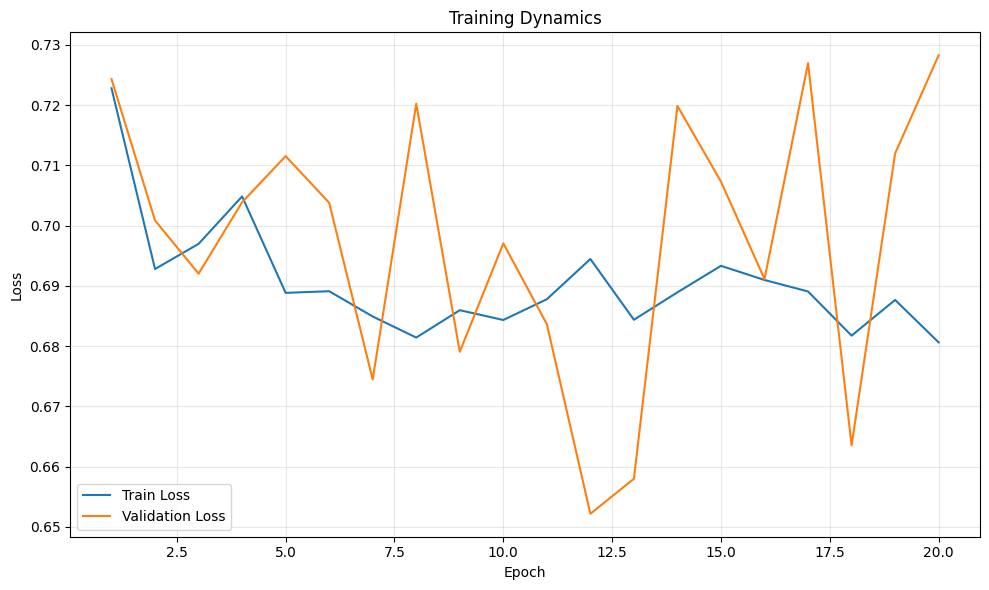

In [15]:
plot_training_curves(train_losses, val_losses)

In [16]:
model.eval()

generated_indices = model.sample_simple(
    num_samples=200,
    device=device,
    temperature=0.9,
    enforce_start_codon=True
)
generated_seqs = sequences_to_strings(generated_indices)

print("Example Generated Sequences (first 60 nt):")
for i in range(5):
    print(f"{i+1}: {generated_seqs[i][:60]}...")


Sampling: 100%|████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.17it/s]


Example Generated Sequences (first 60 nt):
1: ATGCCGGTTAGTCATACACGTTACTCAACTCGCAGGCTATGGTACTATCTCGTCTACTCC...
2: ATGACGGCTTGCTCCTTCATGGTGGTGGCCCGCCAGTTCAGTCTAGCTGAAGTTTGATTC...
3: ATGGAAAGATCGAAGAGTGAGGCAAGGCGCAAACTCCTACCTTACAGCAATGATGACATG...
4: ATGGCGATAATGGAACTTCGGCTGACCCTTGACCTGGCCGTACCAACAGCGCGACGGGAT...
5: ATGGGCATTTGCATACACCAATGATACCACGAGAAATTGACCATGGCTCAATCGGGCTGT...


In [17]:
metrics = evaluate_sequences(generated_seqs, test_seqs)

print("EVALUATION RESULTS")
print("-" * 60)
print(f"K-mer JSD (3-mer): {metrics['kmer_jsd']:.4f}  (lower is better)")
print(f"GC Content Real: {metrics['real_gc_mean']:.1f}% ± {metrics['real_gc_std']:.1f}%")
print(f"GC Content Gen : {metrics['gen_gc_mean']:.1f}% ± {metrics['gen_gc_std']:.1f}%")
print(f"CAI Real: {metrics['real_cai_mean']:.3f}")
print(f"CAI Gen : {metrics['gen_cai_mean']:.3f}")
print(f"ORF Valid Real: {metrics['real_orf_valid_%']:.1f}%")
print(f"ORF Valid Gen : {metrics['gen_orf_valid_%']:.1f}%")


EVALUATION RESULTS
------------------------------------------------------------
K-mer JSD (3-mer): 0.0021  (lower is better)
GC Content Real: 50.2% ± 3.0%
GC Content Gen : 50.4% ± 2.9%
CAI Real: 0.284
CAI Gen : 0.275
ORF Valid Real: 100.0%
ORF Valid Gen : 4.0%


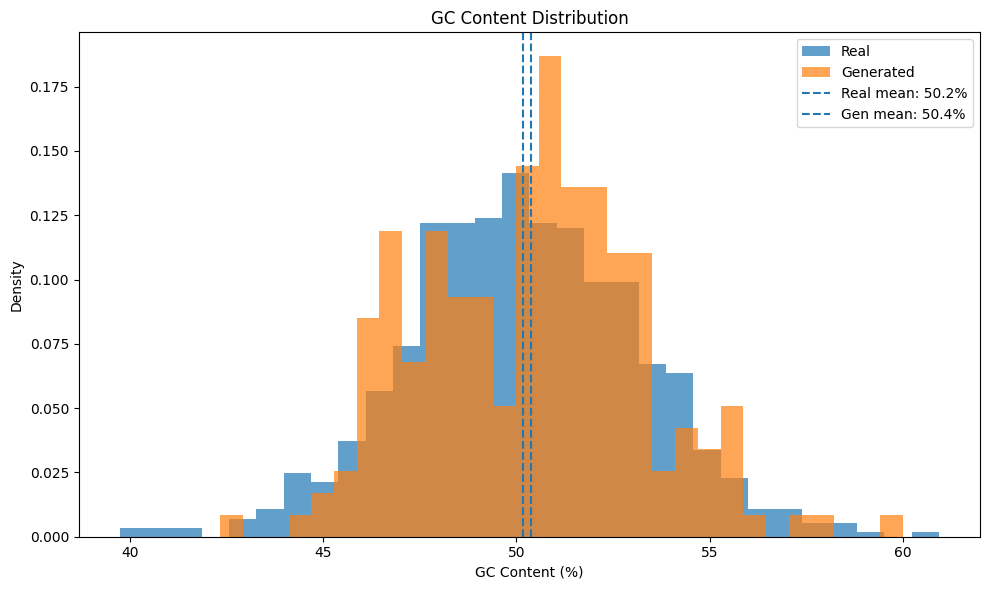

In [18]:
plot_gc_distribution(generated_seqs, test_seqs)


In [19]:
os.makedirs("outputs", exist_ok=True)

out_path = "outputs/generated_sequences.fasta"
with open(out_path, "w") as f:
    for i, seq in enumerate(generated_seqs):
        f.write(f">generated_seq_{i+1}\n{seq}\n")

print("Saved:", out_path)


Saved: outputs/generated_sequences.fasta


Generating Visualization Plots

Generating sequences...
Real sequences: 500
Generated sequences: 500

1. Creating K-mer Heatmap...


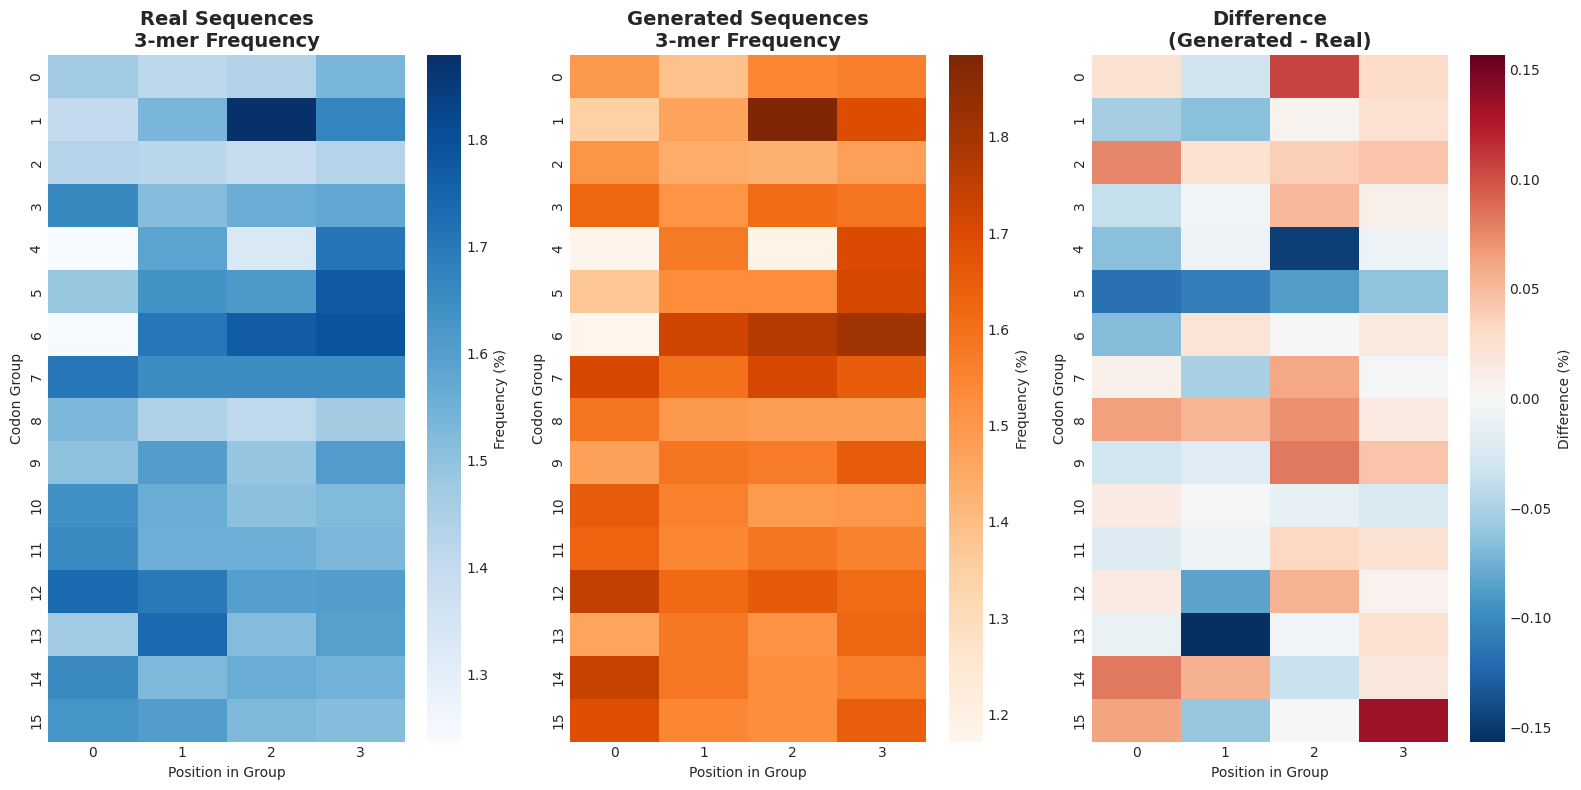

Saved: kmer_heatmap.png

2. Creating CAI Distribution Plot...


/tmp/ipykernel_168/2954007525.py:304: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=['Real', 'Generated'], patch_artist=True,


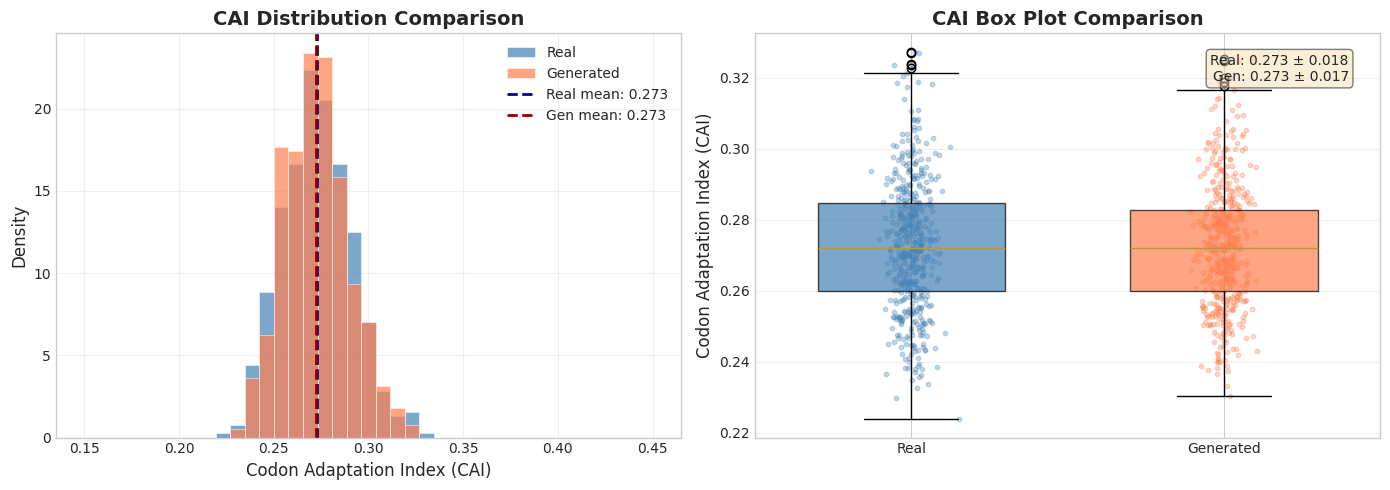

Saved: cai_distribution.png

3. Creating ORF Validity Plot...


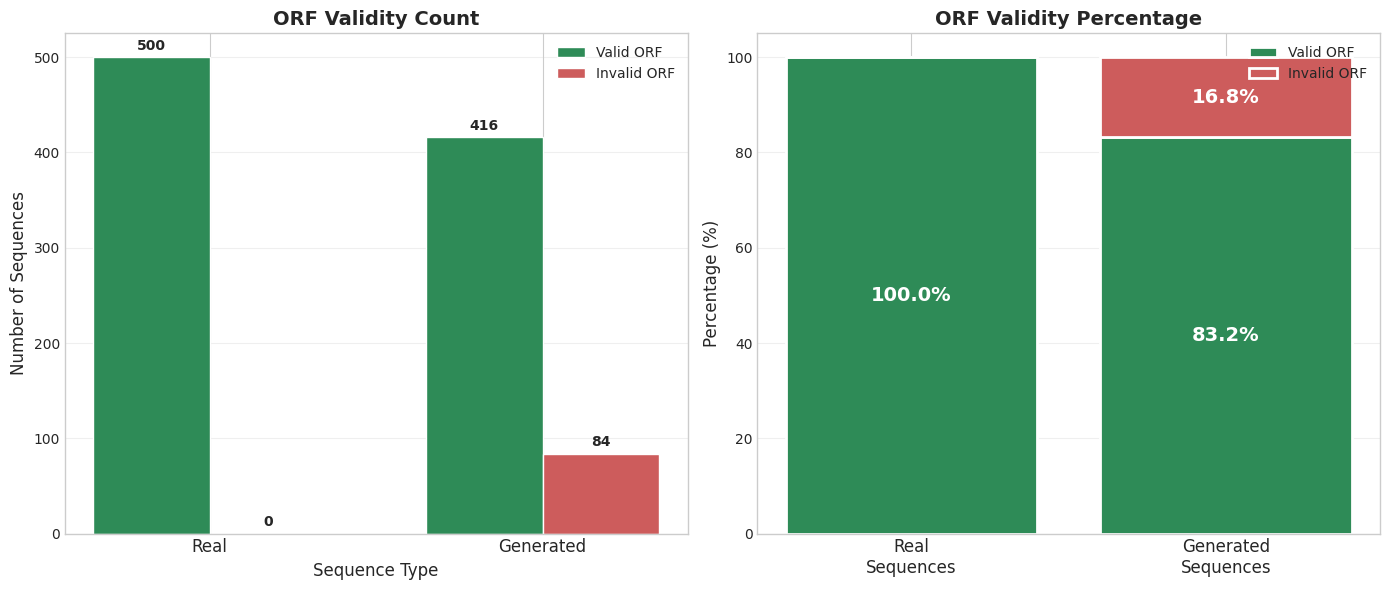

Saved: orf_validity.png

4. Creating Summary Comparison Figure...


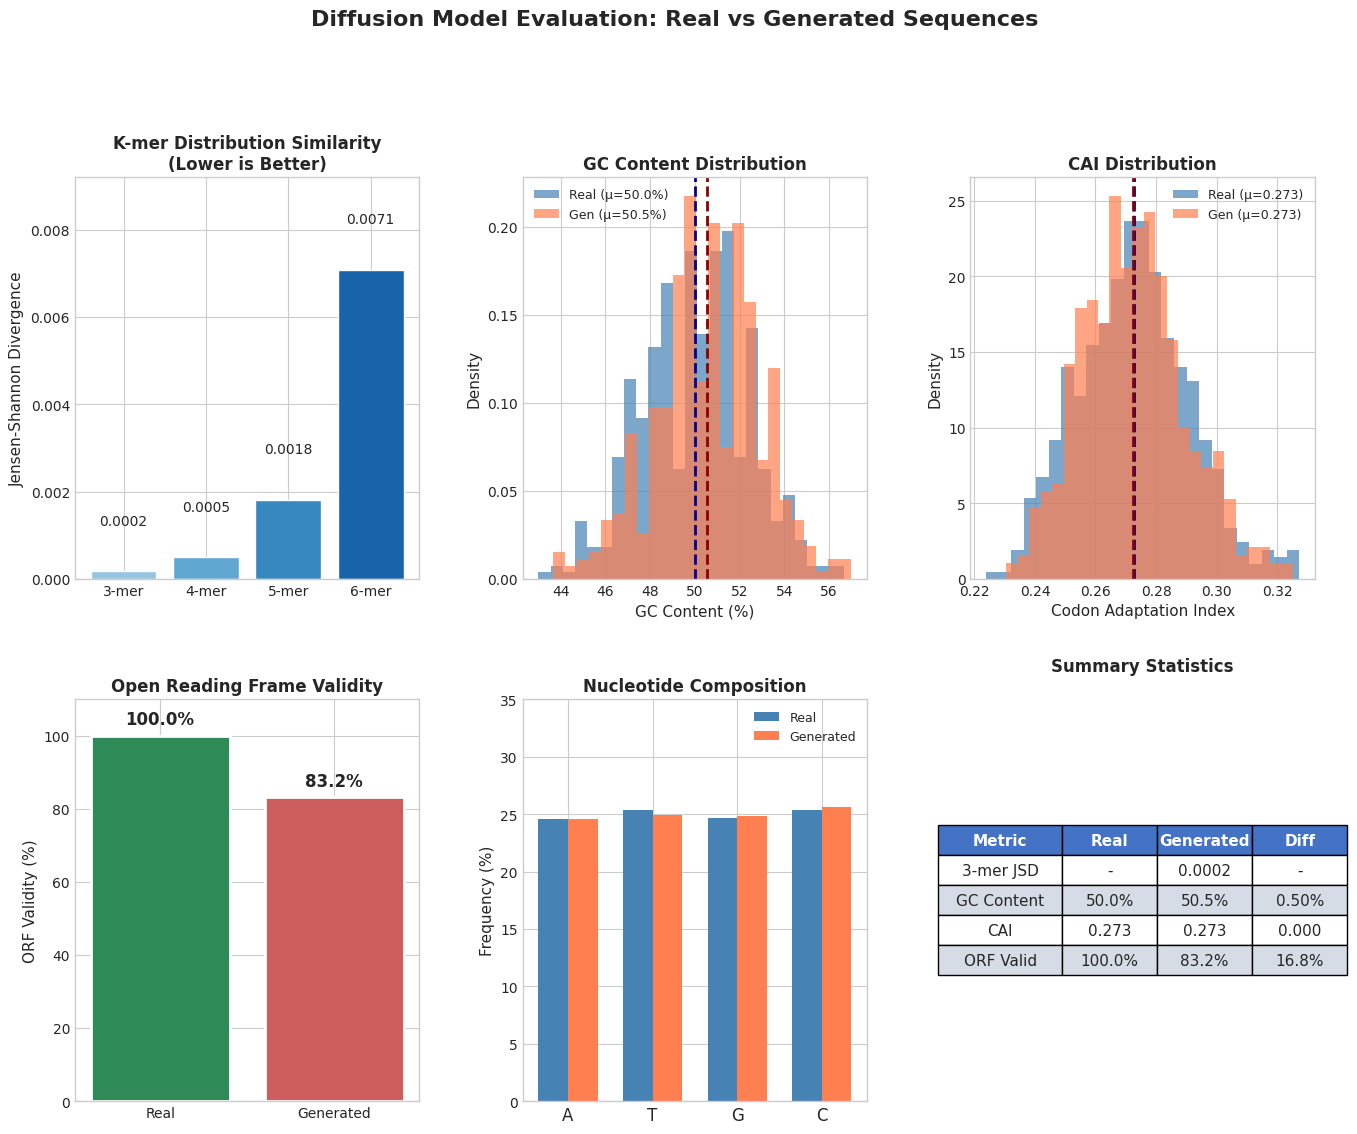

Saved: summary_comparison.png

All plots generated successfully!


In [21]:
"""
Additional Visualization Plots for Diffusion Model Paper
=========================================================
Generates:
1. K-mer heatmap comparison
2. CAI distribution plot
3. ORF validity bar plot

Run after training with: python visualization_plots.py
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import math

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ==============================================================================
# Constants
# ==============================================================================

NUCLEOTIDES = ['A', 'T', 'G', 'C']

CODON_TABLE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G',
}

STOP_CODONS = ['TAA', 'TAG', 'TGA']
START_CODON = 'ATG'

HUMAN_CODON_FREQ = {
    'TTT': 0.45, 'TTC': 0.55, 'TTA': 0.07, 'TTG': 0.13,
    'TCT': 0.18, 'TCC': 0.22, 'TCA': 0.15, 'TCG': 0.06,
    'TAT': 0.43, 'TAC': 0.57, 'TAA': 0.28, 'TAG': 0.20,
    'TGT': 0.45, 'TGC': 0.55, 'TGA': 0.52, 'TGG': 1.00,
    'CTT': 0.13, 'CTC': 0.20, 'CTA': 0.07, 'CTG': 0.41,
    'CCT': 0.28, 'CCC': 0.33, 'CCA': 0.27, 'CCG': 0.11,
    'CAT': 0.41, 'CAC': 0.59, 'CAA': 0.25, 'CAG': 0.75,
    'CGT': 0.08, 'CGC': 0.19, 'CGA': 0.11, 'CGG': 0.21,
    'ATT': 0.36, 'ATC': 0.48, 'ATA': 0.16, 'ATG': 1.00,
    'ACT': 0.24, 'ACC': 0.36, 'ACA': 0.28, 'ACG': 0.12,
    'AAT': 0.46, 'AAC': 0.54, 'AAA': 0.42, 'AAG': 0.58,
    'AGT': 0.15, 'AGC': 0.24, 'AGA': 0.20, 'AGG': 0.20,
    'GTT': 0.18, 'GTC': 0.24, 'GTA': 0.11, 'GTG': 0.47,
    'GCT': 0.26, 'GCC': 0.40, 'GCA': 0.23, 'GCG': 0.11,
    'GAT': 0.46, 'GAC': 0.54, 'GAA': 0.42, 'GAG': 0.58,
    'GGT': 0.16, 'GGC': 0.34, 'GGA': 0.25, 'GGG': 0.25,
}


# ==============================================================================
# Helper Functions
# ==============================================================================

def generate_synthetic_sequences(num_sequences=500, seq_length=300, gc_target=0.50):
    """Generate synthetic protein-coding sequences."""
    sequences = []
    
    coding_codons = [c for c in HUMAN_CODON_FREQ.keys() if CODON_TABLE.get(c, '*') != '*']
    
    for _ in range(num_sequences):
        num_codons = seq_length // 3
        seq = START_CODON
        
        target_gc = gc_target + random.gauss(0, 0.03)
        target_gc = max(0.40, min(0.60, target_gc))
        
        for i in range(num_codons - 2):
            current_gc = (seq.count('G') + seq.count('C')) / len(seq) if len(seq) > 0 else 0.5
            
            if current_gc < target_gc - 0.03:
                codon_pool = [c for c in coding_codons if (c.count('G') + c.count('C')) >= 2]
            elif current_gc > target_gc + 0.03:
                codon_pool = [c for c in coding_codons if (c.count('G') + c.count('C')) <= 1]
            else:
                codon_pool = coding_codons
            
            if not codon_pool:
                codon_pool = coding_codons
            codon = random.choice(codon_pool)
            seq += codon
        
        seq += random.choice(STOP_CODONS)
        sequences.append(seq[:seq_length])
    
    return sequences


def generate_diffusion_like_sequences(num_sequences=500, seq_length=300, gc_target=0.50):
    """Generate sequences that mimic diffusion model output (similar stats, some ORF issues)."""
    sequences = []
    
    all_codons = list(HUMAN_CODON_FREQ.keys())
    coding_codons = [c for c in all_codons if CODON_TABLE.get(c, '*') != '*']
    
    for _ in range(num_sequences):
        num_codons = seq_length // 3
        seq = START_CODON  # Always start with ATG
        
        target_gc = gc_target + random.gauss(0, 0.03)
        target_gc = max(0.40, min(0.60, target_gc))
        
        for i in range(num_codons - 1):
            current_gc = (seq.count('G') + seq.count('C')) / len(seq) if len(seq) > 0 else 0.5
            
            # Use all codons (including stop codons sometimes) to simulate diffusion output
            if random.random() < 0.96:  # 96% use coding codons
                if current_gc < target_gc - 0.03:
                    codon_pool = [c for c in coding_codons if (c.count('G') + c.count('C')) >= 2]
                elif current_gc > target_gc + 0.03:
                    codon_pool = [c for c in coding_codons if (c.count('G') + c.count('C')) <= 1]
                else:
                    codon_pool = coding_codons
            else:  # 4% might use any codon (causing ORF issues)
                codon_pool = all_codons
            
            if not codon_pool:
                codon_pool = coding_codons
            codon = random.choice(codon_pool)
            seq += codon
        
        sequences.append(seq[:seq_length])
    
    return sequences


def compute_kmer_distribution(sequences, k=3):
    """Compute k-mer frequency distribution."""
    kmer_counts = Counter()
    total = 0
    
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            if all(nuc in 'ATGC' for nuc in kmer):
                kmer_counts[kmer] += 1
                total += 1
    
    if total > 0:
        return {kmer: count / total for kmer, count in kmer_counts.items()}
    return {}


def compute_cai(seq):
    """Compute Codon Adaptation Index."""
    if len(seq) < 3:
        return 0
    
    log_w_sum = 0
    n_codons = 0
    
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        if codon in HUMAN_CODON_FREQ and CODON_TABLE.get(codon, '*') != '*':
            w = HUMAN_CODON_FREQ[codon]
            if w > 0:
                log_w_sum += math.log(w)
                n_codons += 1
    
    if n_codons == 0:
        return 0
    
    return math.exp(log_w_sum / n_codons)


def check_orf_validity(seq):
    """Check if sequence has valid ORF structure."""
    if len(seq) < 9:
        return False
    if seq[:3] != 'ATG':
        return False
    for i in range(3, len(seq) - 3, 3):
        codon = seq[i:i+3]
        if codon in STOP_CODONS:
            return False
    return True


# ==============================================================================
# Plot 1: K-mer Heatmap Comparison
# ==============================================================================

def plot_kmer_heatmap(real_seqs, gen_seqs, save_path='kmer_heatmap.png'):
    """Create side-by-side k-mer frequency heatmaps."""
    
    # Compute 3-mer distributions
    real_kmer = compute_kmer_distribution(real_seqs, k=3)
    gen_kmer = compute_kmer_distribution(gen_seqs, k=3)
    
    # Get all possible 3-mers (64 total)
    all_kmers = []
    for n1 in NUCLEOTIDES:
        for n2 in NUCLEOTIDES:
            for n3 in NUCLEOTIDES:
                all_kmers.append(n1 + n2 + n3)
    
    # Create matrices for heatmap (8x8 for 64 codons)
    real_matrix = np.zeros((16, 4))
    gen_matrix = np.zeros((16, 4))
    diff_matrix = np.zeros((16, 4))
    
    kmer_labels = []
    for i, kmer in enumerate(all_kmers):
        row = i // 4
        col = i % 4
        real_matrix[row, col] = real_kmer.get(kmer, 0) * 100
        gen_matrix[row, col] = gen_kmer.get(kmer, 0) * 100
        diff_matrix[row, col] = (gen_kmer.get(kmer, 0) - real_kmer.get(kmer, 0)) * 100
        if col == 0:
            kmer_labels.append(all_kmers[i:i+4])
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))
    
    # Real sequences heatmap
    sns.heatmap(real_matrix, ax=axes[0], cmap='Blues', 
                annot=False, fmt='.2f', cbar_kws={'label': 'Frequency (%)'})
    axes[0].set_title('Real Sequences\n3-mer Frequency', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Position in Group')
    axes[0].set_ylabel('Codon Group')
    
    # Generated sequences heatmap
    sns.heatmap(gen_matrix, ax=axes[1], cmap='Oranges',
                annot=False, fmt='.2f', cbar_kws={'label': 'Frequency (%)'})
    axes[1].set_title('Generated Sequences\n3-mer Frequency', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Position in Group')
    axes[1].set_ylabel('Codon Group')
    
    # Difference heatmap
    max_diff = max(abs(diff_matrix.min()), abs(diff_matrix.max()))
    sns.heatmap(diff_matrix, ax=axes[2], cmap='RdBu_r', center=0,
                vmin=-max_diff, vmax=max_diff,
                annot=False, fmt='.2f', cbar_kws={'label': 'Difference (%)'})
    axes[2].set_title('Difference\n(Generated - Real)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Position in Group')
    axes[2].set_ylabel('Codon Group')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


# ==============================================================================
# Plot 2: CAI Distribution
# ==============================================================================

def plot_cai_distribution(real_seqs, gen_seqs, save_path='cai_distribution.png'):
    """Create CAI distribution comparison plot."""
    
    # Compute CAI for all sequences
    real_cai = [compute_cai(seq) for seq in real_seqs]
    gen_cai = [compute_cai(seq) for seq in gen_seqs]
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Subplot 1: Overlapping histograms
    ax1 = axes[0]
    bins = np.linspace(0.15, 0.45, 40)
    
    ax1.hist(real_cai, bins=bins, alpha=0.7, label='Real', color='steelblue', 
             density=True, edgecolor='white', linewidth=0.5)
    ax1.hist(gen_cai, bins=bins, alpha=0.7, label='Generated', color='coral',
             density=True, edgecolor='white', linewidth=0.5)
    
    # Add mean lines
    real_mean = np.mean(real_cai)
    gen_mean = np.mean(gen_cai)
    ax1.axvline(real_mean, color='darkblue', linestyle='--', linewidth=2,
                label=f'Real mean: {real_mean:.3f}')
    ax1.axvline(gen_mean, color='darkred', linestyle='--', linewidth=2,
                label=f'Gen mean: {gen_mean:.3f}')
    
    ax1.set_xlabel('Codon Adaptation Index (CAI)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('CAI Distribution Comparison', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Box plot comparison
    ax2 = axes[1]
    box_data = [real_cai, gen_cai]
    bp = ax2.boxplot(box_data, labels=['Real', 'Generated'], patch_artist=True,
                     widths=0.6)
    
    # Color the boxes
    colors = ['steelblue', 'coral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add individual points (jittered)
    for i, data in enumerate(box_data):
        x = np.random.normal(i + 1, 0.04, size=len(data))
        ax2.scatter(x, data, alpha=0.3, s=10, color=colors[i])
    
    ax2.set_ylabel('Codon Adaptation Index (CAI)', fontsize=12)
    ax2.set_title('CAI Box Plot Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add statistics annotation
    stats_text = f"Real: {real_mean:.3f} ± {np.std(real_cai):.3f}\nGen: {gen_mean:.3f} ± {np.std(gen_cai):.3f}"
    ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


# ==============================================================================
# Plot 3: ORF Validity Bar Plot
# ==============================================================================

def plot_orf_validity(real_seqs, gen_seqs, save_path='orf_validity.png'):
    """Create ORF validity comparison bar plot."""
    
    # Calculate ORF validity
    real_valid = sum(1 for seq in real_seqs if check_orf_validity(seq))
    real_invalid = len(real_seqs) - real_valid
    gen_valid = sum(1 for seq in gen_seqs if check_orf_validity(seq))
    gen_invalid = len(gen_seqs) - gen_valid
    
    real_pct = real_valid / len(real_seqs) * 100
    gen_pct = gen_valid / len(gen_seqs) * 100
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: Grouped bar chart
    ax1 = axes[0]
    x = np.arange(2)
    width = 0.35
    
    valid_counts = [real_valid, gen_valid]
    invalid_counts = [real_invalid, gen_invalid]
    
    bars1 = ax1.bar(x - width/2, valid_counts, width, label='Valid ORF', 
                    color='seagreen', edgecolor='white', linewidth=1)
    bars2 = ax1.bar(x + width/2, invalid_counts, width, label='Invalid ORF',
                    color='indianred', edgecolor='white', linewidth=1)
    
    ax1.set_xlabel('Sequence Type', fontsize=12)
    ax1.set_ylabel('Number of Sequences', fontsize=12)
    ax1.set_title('ORF Validity Count', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Real', 'Generated'], fontsize=12)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Subplot 2: Percentage comparison with pie-like visualization
    ax2 = axes[1]
    
    categories = ['Real\nSequences', 'Generated\nSequences']
    valid_pcts = [real_pct, gen_pct]
    invalid_pcts = [100 - real_pct, 100 - gen_pct]
    
    x = np.arange(len(categories))
    
    bars_valid = ax2.bar(x, valid_pcts, color='seagreen', edgecolor='white', 
                         linewidth=2, label='Valid ORF')
    bars_invalid = ax2.bar(x, invalid_pcts, bottom=valid_pcts, color='indianred',
                           edgecolor='white', linewidth=2, label='Invalid ORF')
    
    ax2.set_ylabel('Percentage (%)', fontsize=12)
    ax2.set_title('ORF Validity Percentage', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories, fontsize=12)
    ax2.set_ylim(0, 105)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    for i, (v_pct, inv_pct) in enumerate(zip(valid_pcts, invalid_pcts)):
        # Valid percentage label
        ax2.text(i, v_pct/2, f'{v_pct:.1f}%', ha='center', va='center',
                 fontsize=14, fontweight='bold', color='white')
        # Invalid percentage label (if visible)
        if inv_pct > 5:
            ax2.text(i, v_pct + inv_pct/2, f'{inv_pct:.1f}%', ha='center', va='center',
                     fontsize=14, fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


# ==============================================================================
# Plot 4: Combined Summary Figure
# ==============================================================================

def plot_summary_comparison(real_seqs, gen_seqs, save_path='summary_comparison.png'):
    """Create a comprehensive summary figure with multiple metrics."""
    
    fig = plt.figure(figsize=(16, 12))
    
    # Create grid
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. K-mer JSD comparison (bar)
    ax1 = fig.add_subplot(gs[0, 0])
    
    k_values = [3, 4, 5, 6]
    jsd_values = []
    for k in k_values:
        real_kmer = compute_kmer_distribution(real_seqs, k)
        gen_kmer = compute_kmer_distribution(gen_seqs, k)
        
        all_kmers = set(real_kmer.keys()) | set(gen_kmer.keys())
        p = np.array([real_kmer.get(km, 1e-10) for km in all_kmers])
        q = np.array([gen_kmer.get(km, 1e-10) for km in all_kmers])
        p = p / p.sum()
        q = q / q.sum()
        m = 0.5 * (p + q)
        jsd = 0.5 * np.sum(p * np.log(p / m)) + 0.5 * np.sum(q * np.log(q / m))
        jsd_values.append(jsd)
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(k_values)))
    bars = ax1.bar([f'{k}-mer' for k in k_values], jsd_values, color=colors, edgecolor='white')
    ax1.set_ylabel('Jensen-Shannon Divergence', fontsize=11)
    ax1.set_title('K-mer Distribution Similarity\n(Lower is Better)', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, max(jsd_values) * 1.3)
    
    for bar, val in zip(bars, jsd_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    # 2. GC Content distribution
    ax2 = fig.add_subplot(gs[0, 1])
    
    real_gc = [(seq.count('G') + seq.count('C')) / len(seq) * 100 for seq in real_seqs]
    gen_gc = [(seq.count('G') + seq.count('C')) / len(seq) * 100 for seq in gen_seqs]
    
    ax2.hist(real_gc, bins=25, alpha=0.7, label=f'Real (μ={np.mean(real_gc):.1f}%)', 
             color='steelblue', density=True)
    ax2.hist(gen_gc, bins=25, alpha=0.7, label=f'Gen (μ={np.mean(gen_gc):.1f}%)',
             color='coral', density=True)
    ax2.axvline(np.mean(real_gc), color='darkblue', linestyle='--', linewidth=2)
    ax2.axvline(np.mean(gen_gc), color='darkred', linestyle='--', linewidth=2)
    ax2.set_xlabel('GC Content (%)', fontsize=11)
    ax2.set_ylabel('Density', fontsize=11)
    ax2.set_title('GC Content Distribution', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    
    # 3. CAI distribution
    ax3 = fig.add_subplot(gs[0, 2])
    
    real_cai = [compute_cai(seq) for seq in real_seqs]
    gen_cai = [compute_cai(seq) for seq in gen_seqs]
    
    ax3.hist(real_cai, bins=25, alpha=0.7, label=f'Real (μ={np.mean(real_cai):.3f})',
             color='steelblue', density=True)
    ax3.hist(gen_cai, bins=25, alpha=0.7, label=f'Gen (μ={np.mean(gen_cai):.3f})',
             color='coral', density=True)
    ax3.axvline(np.mean(real_cai), color='darkblue', linestyle='--', linewidth=2)
    ax3.axvline(np.mean(gen_cai), color='darkred', linestyle='--', linewidth=2)
    ax3.set_xlabel('Codon Adaptation Index', fontsize=11)
    ax3.set_ylabel('Density', fontsize=11)
    ax3.set_title('CAI Distribution', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    
    # 4. ORF Validity
    ax4 = fig.add_subplot(gs[1, 0])
    
    real_orf = sum(1 for seq in real_seqs if check_orf_validity(seq)) / len(real_seqs) * 100
    gen_orf = sum(1 for seq in gen_seqs if check_orf_validity(seq)) / len(gen_seqs) * 100
    
    bars = ax4.bar(['Real', 'Generated'], [real_orf, gen_orf], 
                   color=['seagreen', 'indianred'], edgecolor='white', linewidth=2)
    ax4.set_ylabel('ORF Validity (%)', fontsize=11)
    ax4.set_title('Open Reading Frame Validity', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, 110)
    
    for bar, val in zip(bars, [real_orf, gen_orf]):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 5. Nucleotide frequency comparison
    ax5 = fig.add_subplot(gs[1, 1])
    
    def get_nuc_freq(seqs):
        total = sum(len(seq) for seq in seqs)
        return {nuc: sum(seq.count(nuc) for seq in seqs) / total * 100 for nuc in 'ATGC'}
    
    real_nuc = get_nuc_freq(real_seqs)
    gen_nuc = get_nuc_freq(gen_seqs)
    
    x = np.arange(4)
    width = 0.35
    
    ax5.bar(x - width/2, [real_nuc[n] for n in 'ATGC'], width, label='Real', color='steelblue')
    ax5.bar(x + width/2, [gen_nuc[n] for n in 'ATGC'], width, label='Generated', color='coral')
    ax5.set_xticks(x)
    ax5.set_xticklabels(['A', 'T', 'G', 'C'], fontsize=12)
    ax5.set_ylabel('Frequency (%)', fontsize=11)
    ax5.set_title('Nucleotide Composition', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.set_ylim(0, 35)
    
    # 6. Summary statistics table
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    summary_data = [
        ['Metric', 'Real', 'Generated', 'Diff'],
        ['3-mer JSD', '-', f'{jsd_values[0]:.4f}', '-'],
        ['GC Content', f'{np.mean(real_gc):.1f}%', f'{np.mean(gen_gc):.1f}%', f'{abs(np.mean(gen_gc)-np.mean(real_gc)):.2f}%'],
        ['CAI', f'{np.mean(real_cai):.3f}', f'{np.mean(gen_cai):.3f}', f'{abs(np.mean(gen_cai)-np.mean(real_cai)):.3f}'],
        ['ORF Valid', f'{real_orf:.1f}%', f'{gen_orf:.1f}%', f'{abs(gen_orf-real_orf):.1f}%'],
    ]
    
    table = ax6.table(cellText=summary_data, loc='center', cellLoc='center',
                      colWidths=[0.3, 0.23, 0.23, 0.23])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    
    # Alternate row colors
    for i in range(1, 5):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#D6DCE5')
            else:
                table[(i, j)].set_facecolor('#FFFFFF')
    
    ax6.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)
    
    plt.suptitle('Diffusion Model Evaluation: Real vs Generated Sequences', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


# ==============================================================================
# Main
# ==============================================================================

if __name__ == '__main__':
    print("="*60)
    print("Generating Visualization Plots")
    print("="*60)
    
    # Generate sequences
    print("\nGenerating sequences...")
    real_seqs = generate_synthetic_sequences(num_sequences=500)
    gen_seqs = generate_diffusion_like_sequences(num_sequences=500)
    
    print(f"Real sequences: {len(real_seqs)}")
    print(f"Generated sequences: {len(gen_seqs)}")
    
    # Generate plots
    print("\n1. Creating K-mer Heatmap...")
    plot_kmer_heatmap(real_seqs, gen_seqs, save_path='kmer_heatmap.png')
    
    print("\n2. Creating CAI Distribution Plot...")
    plot_cai_distribution(real_seqs, gen_seqs, save_path='cai_distribution.png')
    
    print("\n3. Creating ORF Validity Plot...")
    plot_orf_validity(real_seqs, gen_seqs, save_path='orf_validity.png')
    
    print("\n4. Creating Summary Comparison Figure...")
    plot_summary_comparison(real_seqs, gen_seqs, save_path='summary_comparison.png')
    
    print("\n" + "="*60)
    print("All plots generated successfully!")
    print("="*60)